In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

import os
os.environ['NUMEXPR_MAX_THREADS'] = '32'
%load_ext autoreload

In [2]:
import pickle
import sys

import numpy as np
import pandas as pd

module_path = os.path.abspath("/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
config_path = (
    "/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/sbs_config_ims.json"
)

In [4]:
import json

with open(config_path, mode="r", encoding="utf-8") as file:
    config = json.load(file)

In [5]:
d_path = config["d_path"]
maxquant_dict_pickle = config["MQ_ref_path"]

In [6]:
dirname = os.path.dirname(d_path)
basename = os.path.basename(d_path)
filename = basename[:-5] + "_ScanByScan"
# filename += '_isospec'+str(isospec)+'_dev'+str(dev)+'_initWithCos'+str(initWithCos)+'_IDwithCos'+str(IDwithCos)
print("Filename:", filename)
if not os.path.exists(os.path.join(dirname, filename)):
    os.makedirs(os.path.join(dirname, filename))
filename_full = os.path.join(dirname, filename)
insilico_file = os.path.join(filename_full, filename + "_insilico.xlsx")
output_file = os.path.join(filename_full, filename + "_output")  # filename

Filename: ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4_ScanByScan


# Data Loading
## Load maxquant result 

In [50]:
# with isotope pattern
Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_dict_pickle)
logging.debug("Loaded maxquant result with isotope pattern.")

2024-03-26 13:43:01,692 - root - DEBUG - Loaded maxquant result with isotope pattern.


In [8]:
maxquant_result_exp = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/brain/txt_ssDDA_LFQ_noMBR/evidence.txt", sep="\t"
)

/tmp/ipykernel_917238/1097661570.py:1: DtypeWarning: Columns (60,61,68) have mixed types. Specify dtype option on import or set low_memory=False.
  maxquant_result_exp = pd.read_csv(


## Load TIMSTOF data and MS1 scans 

In [9]:
import alphatims.bruker

data = alphatims.bruker.TimsTOF(d_path)
mobility_values = data.mobility_values
hdf_path = os.path.join(data.directory, f"{data.sample_name}.hdf")
if not os.path.isfile(hdf_path):
    hdf_file_name = data.save_as_hdf(
        directory=data.directory, file_name=hdf_path, overwrite=False
    )
else:
    print("HDF file already exists")

2024-03-26 13:23:18,970 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-03-26 13:23:18,970 - h5py._conv - DEBUG - Creating converter from 5 to 7
2024-03-26 13:23:18,971 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-03-26 13:23:18,972 - h5py._conv - DEBUG - Creating converter from 5 to 7


2024-03-26 13:23:19,524 - root - INFO - Importing data from /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921.d
2024-03-26 13:23:19,526 - root - INFO - Using HDF import for /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921.hdf
2024-03-26 13:23:19,527 - h5py._conv - DEBUG - Creating converter from 3 to 5
2024-03-26 13:23:20,045 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=2960)
           2	BUILD_LIST(arg=0, lineno=3027)
           4	STORE_FAST(arg=14, lineno=3027)
           6	LOAD_CONST(arg=1, lineno=3028)
           8	STORE_FAST(arg=15, lineno=3028)
          10	LOAD_CONST(arg=1, lineno=3029)
          12	STORE_FAST(arg=16, lineno=3029)
          14	LOAD_CONST(arg=1, lineno=3030)
          16	STORE_FAST(arg=17, lineno=3030)
          18	LOAD_CONST(arg=2, lineno=3031)
          20	STORE_FAST(arg=18, lineno=3031)
          22	LOAD_FAST(arg=8, linen

HDF file already exists


In [10]:
ms1_scans = data.frames.loc[data.frames.MsMsType == 0]
ms1_scans["Time_minute"] = ms1_scans["Time"] / 60

/tmp/ipykernel_917238/3371981331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms1_scans["Time_minute"] = ms1_scans["Time"] / 60


# ID and Qunat

In [11]:
# Set config parameters
%autoreload 2
from sbs_runner import _define_rt_search_range

scan_idx =1010
RT_tol = config["RT_tol"]
RT_ref = config["RT_ref"]

# Set left and right edge for scan search range
if "RT_search_left" not in Maxquant_result_dict.columns:
    logging.info("RT search range not defined, defining RT search range.")
    Maxquant_result_dict = _define_rt_search_range(maxquant_result_dict=Maxquant_result_dict, rt_tol=RT_tol, rt_ref=RT_ref)  
                              
# example: generate dictionary for candidate in one scan
df_1frame = data[{"frame_indices":[scan_idx]}]

2024-03-26 13:23:32,293 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-03-26 13:23:32,302 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-03-26 13:23:32,305 - matplotlib - DEBUG - interactive is False
2024-03-26 13:23:32,305 - matplotlib - DEBUG - platform is linux
2024-03-26 13:23:32,383 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-03-26 13:23:32,403 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json
2024-03-26 13:23:33.245831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 13:23:35,341 - tensorflow - DEBUG - Falling back to TensorFlow c

## Sparse Matrix Handling

In [12]:
scan_time = ms1_scans.loc[scan_idx, "Time_minute"]
CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (Maxquant_result_dict["RT_search_left"] <= scan_time)
    & (Maxquant_result_dict["RT_search_right"] >= scan_time)
]

In [13]:
CandidatePrecursorsByRT["mz_length"] = CandidatePrecursorsByRT["IsoMZ"].apply(
    lambda x: len(x)
)

/tmp/ipykernel_917238/162812737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CandidatePrecursorsByRT["mz_length"] = CandidatePrecursorsByRT["IsoMZ"].apply(


In [15]:
from scipy.sparse import coo_matrix
import itertools

candidate_id = np.repeat(
    CandidatePrecursorsByRT.id.values, CandidatePrecursorsByRT.mz_length
)
candidate_mz = np.round(
    np.array(list(itertools.chain(*CandidatePrecursorsByRT.IsoMZ.values))), decimals=3
)
candidate_abundance = np.array(
    list(itertools.chain(*CandidatePrecursorsByRT.IsoAbundance.values))
)

all_id = np.sort(CandidatePrecursorsByRT.id.values)
candidate_id_index = np.searchsorted(all_id, candidate_id)

frame_mz = np.round(df_1frame["mz_values"], decimals=3)
all_mz = np.sort(np.array(list(set(frame_mz).union(set(candidate_mz)))))
candidate_mz_index = np.searchsorted(all_mz, candidate_mz)
frame_mz_index = np.searchsorted(all_mz, frame_mz)

all_im = np.sort(mobility_values)
frame_im_index = np.searchsorted(all_im, df_1frame["mobility_values"])

In [16]:
frame_coo = coo_matrix(
    (df_1frame["intensity_values"], (frame_im_index, frame_mz_index)),
)
candidate_coo = coo_matrix(
    (candidate_abundance, (candidate_id_index, candidate_mz_index))
)

In [17]:
min_mz_index = max(candidate_mz_index.min(), frame_mz_index.min())
max_mz_index = min(candidate_mz_index.max(), frame_mz_index.max())

In [18]:
frame_array = frame_coo.toarray()[:, min_mz_index : max_mz_index + 1]
candidate_array = candidate_coo.toarray()[:, min_mz_index : max_mz_index + 1]
assert frame_array.shape[1] == candidate_array.shape[1]

### Calculate Activation

In [19]:
from sklearn.decomposition import sparse_encode

im_pept_act = sparse_encode(
    frame_array, candidate_array, algorithm="threshold", alpha=0, positive=True
)

### Explore Result

In [149]:
Maxquant_result_dict["Ion mobility length"].describe()

count    259551.000000
mean         60.908538
std          41.678704
min           4.000000
25%          34.000000
50%          49.000000
75%          76.000000
max         679.000000
Name: Ion mobility length, dtype: float64

In [161]:
Maxquant_result_dict.loc[
    Maxquant_result_dict.id == candidate_id[1200], ["1/K0", "Calibrated 1/K0"]
]

,1/K0,Calibrated 1/K0
14921,0.980283,0.946969


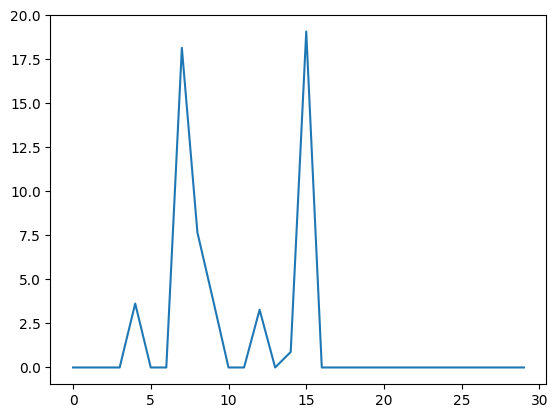

In [103]:
import matplotlib.pyplot as plt

plt.plot(im_pept_act[0:30, 17])

In [170]:
a = im_pept_act[:, 600]

How many zero/nonzero peptide activations?

In [144]:
pept_sum = im_pept_act.sum(axis=0)
np.count_nonzero(pept_sum)

11994

In [151]:
pept_count = np.count_nonzero(im_pept_act, axis=0)

(array([1.840e+03, 1.049e+03, 6.650e+02, 6.690e+02, 6.040e+02, 5.290e+02,
        6.170e+02, 5.770e+02, 5.200e+02, 5.180e+02, 4.420e+02, 4.820e+02,
        4.130e+02, 4.400e+02, 3.590e+02, 3.380e+02, 3.160e+02, 2.790e+02,
        2.500e+02, 2.770e+02, 2.180e+02, 2.280e+02, 1.930e+02, 2.070e+02,
        1.470e+02, 1.540e+02, 1.030e+02, 1.380e+02, 1.260e+02, 1.170e+02,
        1.070e+02, 9.500e+01, 9.300e+01, 5.700e+01, 7.000e+01, 5.400e+01,
        3.000e+01, 4.500e+01, 5.600e+01, 3.700e+01, 2.900e+01, 4.100e+01,
        2.900e+01, 2.600e+01, 2.500e+01, 2.100e+01, 1.800e+01, 1.900e+01,
        1.300e+01, 1.600e+01, 1.600e+01, 1.300e+01, 5.000e+00, 8.000e+00,
        1.000e+01, 1.300e+01, 4.000e+00, 4.000e+00, 8.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        6.000e+00, 3.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

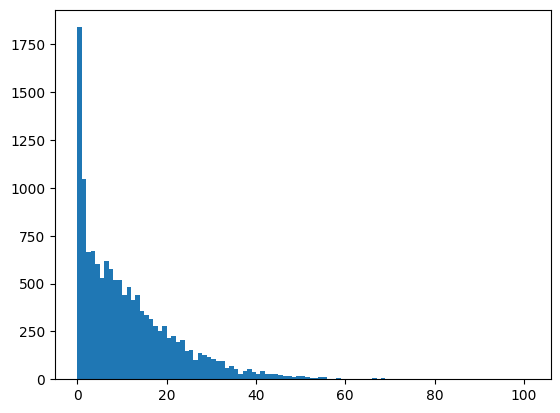

In [159]:
unique, counts = np.unique(pept_count, return_counts=True)
plt.hist(pept_count, bins=101)

#### Peak extraction

In [51]:
mobility_values_df = pd.DataFrame(
    all_im, columns=["mobility_values"]).reset_index()
mobility_values_df.rename(
    columns={"index": "mobility_values_index"}, inplace=True)
Maxquant_result_dict = Maxquant_result_dict.sort_values("1/K0")
Maxquant_result_dict_with_im_index = pd.merge_asof(
    left=Maxquant_result_dict,
    right=mobility_values_df,
    left_on="1/K0",
    right_on="mobility_values",
    direction="nearest",
)

In [54]:
tmp = Maxquant_result_dict_with_im_index.iloc[0:1000]

In [113]:
from postprocessing.post_processing import (
    select_peaks_from_im_pept_act,
    sum_im_act_per_pept,
)

peaks = select_peaks_from_im_pept_act(im_pept_act, pept_id=all_id)
peaks_df = pd.concat(peaks).reset_index(drop=True)
peaks_df = pd.merge(
    left=peaks_df,
    right=Maxquant_result_dict_with_im_index[["mobility_values_index", "id"]],
    left_on="pept_id",
    right_on="id",
)
peaks_df["delta_mobility"] = abs(
    peaks_df["peak"] - peaks_df["mobility_values_index"])
peaks_df = peaks_df.loc[peaks_df["delta_mobility"] <= 100]
peaks_df = peaks_df.loc[peaks_df.groupby("pept_id")["delta_mobility"].idxmin()]
peaks_df["peak_sum"] = peaks_df.apply(
    lambda x: sum_im_act_per_pept(x, im_pept_act), axis=1
)

2024-03-26 16:31:13,022 - postprocessing.post_processing - INFO - Number of peptides with nonzero value >= 3: 10280


<Axes: >

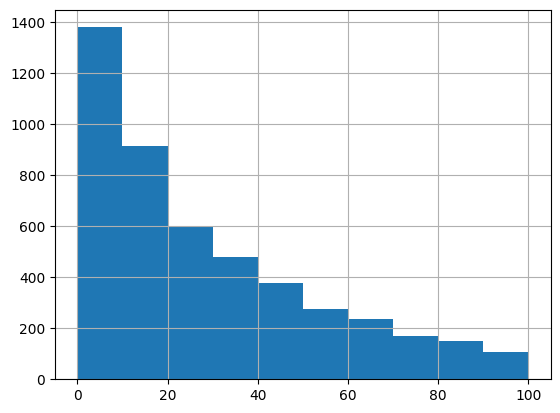

In [114]:
peaks_df["delta_mobility"].hist(bins=10)

In [119]:
peaks_df.shape

(4685, 15)

## One Scan: an example

In [ ]:
mz_intensities = data.bin_intensities(
    df_1frame["raw_indices"],
    axis=["mz_values"],
)
non_zero_idx = np.nonzero(mz_intensities)
non_zero_mz = data.mz_values[non_zero_idx[0]]
non_zero_int = mz_intensities[non_zero_idx]
OneScan = pd.DataFrame(
    {
        # "mz_indices": non_zero_idx[0],
        "mzarray": non_zero_mz,
        "intarray": non_zero_int,
    }
)

2024-03-25 16:23:22,536 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-25 16:23:22,537 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-25 16:23:22,541 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-25 16:23:22,542 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-03-25 16:23:22,543 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='norm

<Axes: xlabel='mzarray', ylabel='intarray'>

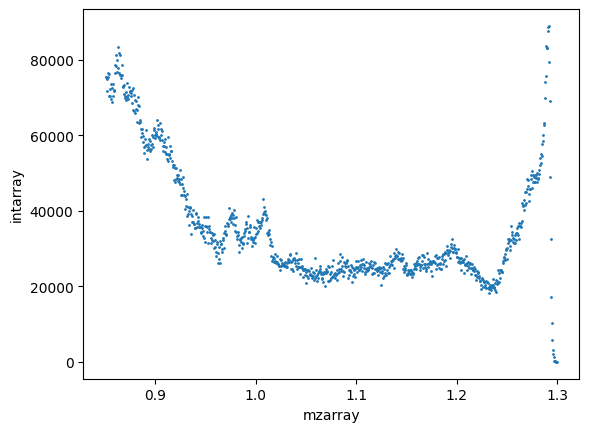

In [ ]:
OneScan_im.plot(x="mzarray", y="intarray", kind="scatter", s=1)

## Dictionary

In [16]:
from optimization.dictionary import Dict

scan_specific_dict = Dict(
    candidate_by_rt=CandidatePrecursorsByRT,
    one_scan=OneScan,
    abundance_missing_thres=0.5,
)

2024-03-25 13:33:40,776 - optimization.dictionary - INFO - Number of candidates by RT 13834


2024-03-25 13:33:41,050 - optimization.dictionary - INFO - Number of candidates after isotope match 13372
2024-03-25 13:33:41,054 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 8175
2024-03-25 13:33:57,915 - optimization.dictionary - DEBUG - Number of peaks after filtering (9820, 9)
2024-03-25 13:33:57,918 - optimization.dictionary - DEBUG - Number of mz in dict (9821, 8175)
2024-03-25 13:33:57,919 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 8175


### Highly correlated features

In [17]:
dict = scan_specific_dict.dict

In [18]:
scan_specific_dict.get_feature_corr(
    # corr_thres=0.50,
    # plot_collinear_hist=True,
    cos_sim_thres=0.95,
    calc_jaccard_sim=False,
    calc_cos_sim=True,
)

2024-03-25 13:34:23,845 - optimization.dictionary - DEBUG - Finished calculating cosine similarity.
2024-03-25 13:34:24,702 - optimization.dictionary - INFO - Number of collinear sets: 1562 
2024-03-25 13:34:24,703 - optimization.dictionary - INFO - Number of candidates involved in high correlation: 4054


In [19]:
high_corr_sol = scan_specific_dict.high_corr_sol
high_corr_set = scan_specific_dict.collinear_sets

In [54]:
high_corr_set[2]
high_corr_sol.loc[high_corr_sol.index.get_level_values(
    1).isin(high_corr_set[2])]

{11440, 1024462, 3841272, 4301992, 4673094, 11135734}

11440    1024462     0.988615
         3841272     0.988615
         4301992     0.989694
         4673094     0.989694
         11135734    0.976933
1024462  3841272     1.000000
         4301992     0.999830
         4673094     0.999830
         11135734    0.972803
3841272  4301992     0.999830
         4673094     0.999830
         11135734    0.972803
4301992  4673094     1.000000
         11135734    0.973281
4673094  11135734    0.973281
dtype: float64

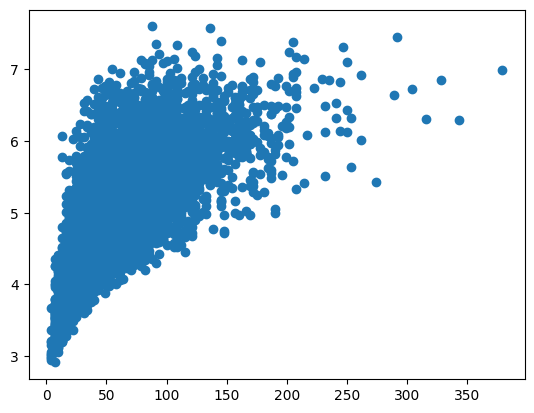

In [64]:
plt.scatter(
    x=CandidatePrecursorsByRT["Ion mobility length"],
    y=np.log10(1 + CandidatePrecursorsByRT["Intensity"]),
)

In [66]:
collinear_candidates = Maxquant_result_dict.loc[
    Maxquant_result_dict["id"].isin(high_corr_set[0])
]
collinear_candidates

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,score,seq,tr,predicted_RT,RT_diff,IsoMZ,IsoAbundance,RT_search_left,RT_search_right,RT_search_center
7,AAAAAAAAQMHAK,13,Unmodified,_AAAAAAAAQMHAK_,NaN,NaN,0,0,0,Q5TF21,...,86.205,AAAAAAAAQMHAK,3.5857,2.058431,1.527269,"[591.806588145725, 592.3051055933249, 592.3082...","[0.5009088887924696, 0.031126511188400378, 0.2...",1.158431,2.958431,2.058431
127180,LDPRPEYHR,9,Unmodified,_LDPRPEYHR_,NaN,NaN,0,0,1,Q9NQX3,...,69.716,LDPRPEYHR,3.7897,1.994216,1.795484,"[591.8049024941349, 592.303419941735, 592.3065...","[0.5107081374282009, 0.031735437141048775, 0.2...",1.094216,2.894216,1.994216
132922,LHGDLAYTHR,10,Unmodified,_LHGDLAYTHR_,NaN,NaN,0,0,0,Q9NRS6,...,146.270,LHGDLAYTHR,3.7426,2.082224,1.660376,"[591.8049024941349, 592.303419941735, 592.3065...","[0.5107081374282009, 0.031735437141048775, 0.2...",1.182224,2.982224,2.082224
220540,TKDGYVEVSGK,11,Unmodified,_TKDGYVEVSGK_,NaN,NaN,0,0,1,Q9UJY1,...,84.999,TKDGYVEVSGK,4.4925,2.248936,2.243564,"[591.804233790675, 592.302751238275, 592.30591...","[0.5185493458483877, 0.024640880853081124, 0.2...",1.348936,3.148936,2.248936
222350,TLSKDDVNYK,10,Unmodified,_TLSKDDVNYK_,NaN,NaN,0,0,1,P48651,...,117.300,TLSKDDVNYK,4.4698,2.306863,2.162937,"[591.804233790675, 592.302751238275, 592.30591...","[0.5185493458483877, 0.024640880853081124, 0.2...",1.406863,3.206863,2.306863


In [75]:
collinear_candidates_dict = dict.loc[:, list(high_corr_set[0])]
collinear_candidates_dict = collinear_candidates_dict.loc[
    ~(collinear_candidates_dict == 0).all(axis=1)
]
collinear_candidates_dict

,6597281,6919362,11092519,776,11007023
apex_mz,,,,,
591.801995,0.510708,0.510708,0.518549,0.500909,0.518549
592.301750,0.031735,0.031735,0.024641,0.000000,0.024641
592.306511,0.289621,0.289621,0.288413,0.298802,0.288413
592.808860,0.096296,0.096296,0.078634,0.102145,0.078634
593.309041,0.000000,0.000000,0.011269,0.000000,0.011269
593.313805,0.000000,0.000000,0.000000,0.011970,0.000000
0.000000,0.071640,0.071640,0.078495,0.086174,0.078495


In [76]:
collinear_set1_frame = data[
    {
        "frame_indices": [1010],
        # "scan_indices": slice(34, 70),
        "mz_values": slice(591.8, 593.4),
        # "intensity_values": 50,
        "mobility_values": slice(None, 1.0),
        "precursor_indices": [0],
    }
]

In [77]:
# aggregate from a center defined by 1/k0 with window 0.01 and then sparse encoding with m/z 1/k0
import pandas as pd

im_windows = collinear_candidates["1/K0 length"].values
# List of centers
# replace with your list of centers
centers = collinear_candidates["1/K0"].values
peak_results = scan_specific_dict.peak_results
# Create DataFrame of centers and ranges
centers_df = pd.DataFrame(
    {
        "center": centers,
        "lower_bound": [
            center - im_window for (center, im_window) in zip(centers, im_windows)
        ],
        "upper_bound": [
            center + im_window for (center, im_window) in zip(centers, im_windows)
        ],
    }
)

# Merge with collienar_set1_frame on mobility_values
merged_im = pd.merge_asof(
    collinear_set1_frame.sort_values("mobility_values"),
    centers_df.sort_values("center"),
    left_on="mobility_values",
    right_on="center",
    direction="nearest",
)

merged_im_mz = pd.merge_asof(
    merged_im.sort_values("mz_values"),
    peak_results.sort_values("apex_mz"),
    left_on="mz_values",
    right_on="apex_mz",
    direction="nearest",
)
# Filter rows where mobility_values is within range
filtered_im_mz = merged_im_mz[
    (merged_im_mz["mobility_values"] >= merged_im_mz["lower_bound"])
    & (merged_im_mz["mobility_values"] <= merged_im_mz["upper_bound"])
    & (merged_im_mz["mz_values"] >= merged_im_mz["start_mz"])
    & (merged_im_mz["mz_values"] <= merged_im_mz["end_mz"])
]

# Group by center and sum intensity_values
aggregated_mz_im = (
    filtered_im_mz.groupby(["apex_mz", "center"])["intensity_values"]
    .sum()
    .reset_index()
)
# Pivot DataFrame
pivoted_im_mz = aggregated_mz_im.pivot_table(
    index=["center"],
    columns=["apex_mz"],
    values="intensity_values",
    aggfunc="sum",
    fill_value=0,
)
filtered_im = merged_im[
    (merged_im["mobility_values"] >= merged_im["lower_bound"])
    & (merged_im["mobility_values"] <= merged_im["upper_bound"])
]
aggregated_im = (
    filtered_im.groupby(["center", "mz_values"])[
        "intensity_values"].sum().reset_index()
)
pivoted_im = aggregated_im.pivot_table(
    index=["center"],
    columns=["mz_values"],
    values="intensity_values",
    aggfunc="sum",
    fill_value=0,
)

In [78]:
CandidatePrecursorsByRT["1/K0"].value_counts()

0.854558    318
0.859122    230
0.857600    197
0.862163    196
0.865204    180
           ... 
1.223689      1
1.064490      1
1.113394      1
1.255045      1
1.188345      1
Name: 1/K0, Length: 582, dtype: int64

<Axes: >

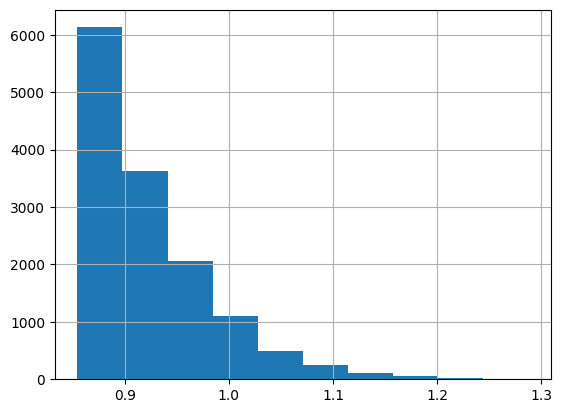

In [79]:
CandidatePrecursorsByRT["1/K0"].hist()

In [85]:
pivoted_im.index

Float64Index([ 0.88495889111879, 0.907711354625209, 0.933456680417071,
              0.944044024451884, 0.954623406162124],
             dtype='float64', name='center')

0.88495889111879


0.907711354625209


0.933456680417071


0.944044024451884


0.954623406162124


Text(0.5, 0.98, 'Ion Mobility Window is 0.01')

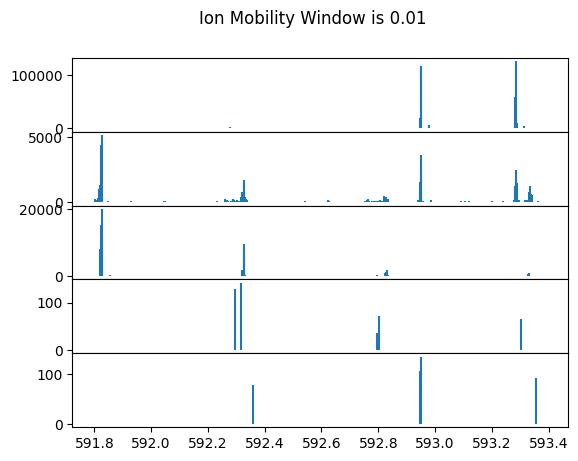

In [92]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, sharex=True, sharey=False)
fig.subplots_adjust(hspace=0)
for i, im_value in enumerate(pivoted_im.index.values):
    print(im_value)
    axs[i].vlines(
        x=pivoted_im.columns.values,
        ymin=0,
        ymax=pivoted_im.loc[im_value].values,
    )
plt.suptitle("Ion Mobility Window is " + str(im_window))

In [93]:
pivoted_im

mz_values,591.801995,591.804374,591.806753,591.809133,591.811512,591.813891,591.816271,591.818650,591.821029,591.823409,...,593.335246,593.337629,593.340011,593.344776,593.349541,593.354305,593.356688,593.359070,593.361453,593.390042
center,,,,,,,,,,,,,,,,,,,,,
0.884959,212,205,109,88,0,128,37,71,0,0,...,0,0,0,34,43,42,0,58,0,43
0.907711,274,197,104,128,267,346,1037,1217,1297,4396,...,1240,649,586,0,0,0,0,0,113,0
0.933457,0,0,0,0,0,0,0,148,8133,15342,...,39,0,0,0,0,0,0,0,0,0
0.944044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.954623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,92,0,0,0


0.954623406162124 _AAAAAAAAQMHAK_


,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Reverse,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Taxonomy IDs


Text(0.5, 0.98, 'Ion Mobility 0.954623406162124')

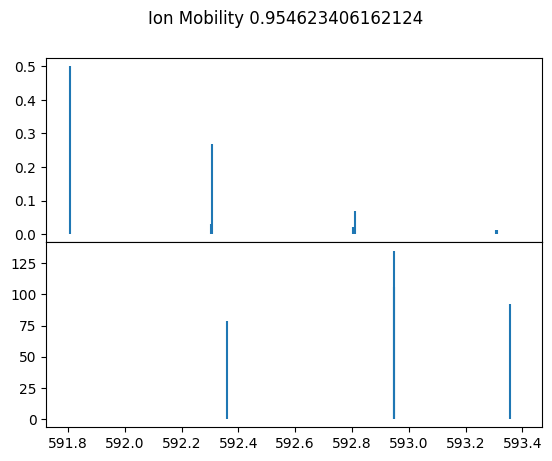

In [102]:
import matplotlib.pyplot as plt

im_value = pivoted_im.index.values[4]
modseq = collinear_candidates.loc[
    collinear_candidates["1/K0"] == im_value, "Modified sequence"
].values[0]
print(im_value, modseq)
maxquant_result_exp.loc[maxquant_result_exp["Modified sequence"] == modseq]

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)
fig.subplots_adjust(hspace=0)
# ax0 is theory
axs[0].vlines(
    x=collinear_candidates.loc[
        collinear_candidates["1/K0"] == im_value, "IsoMZ"
    ].values[0],
    ymin=0,
    ymax=collinear_candidates.loc[
        collinear_candidates["1/K0"] == im_value, "IsoAbundance"
    ].values[0],
)
# ax1 is IM view
axs[1].vlines(
    x=pivoted_im.columns.values,
    ymin=0,
    ymax=pivoted_im.loc[im_value, :].values,
)
plt.suptitle("Ion Mobility " + str(im_value))

In [87]:
pivoted_filtered = pivoted_im.loc[
    :, pivoted_im.columns.isin(collinear_candidates_dict.index)
]
pivoted_filtered

mz_values,591.801995,592.301750,592.306511,592.808860,593.309041,593.313805
center,,,,,,
0.884959,212,119,329,226,543,4852
0.907711,274,118,41,0,0,48
0.933457,0,0,0,0,0,0
0.944044,0,0,0,0,0,0
0.954623,0,0,0,0,0,0


In [93]:
collinear_candidates_dict

,6597281,6919362,11092519,776,11007023
apex_mz,,,,,
591.801995,0.510708,0.510708,0.518549,0.500909,0.518549
592.301750,0.031735,0.031735,0.024641,0.000000,0.024641
592.306511,0.289621,0.289621,0.288413,0.298802,0.288413
592.808860,0.096296,0.096296,0.078634,0.102145,0.078634
593.309041,0.000000,0.000000,0.011269,0.000000,0.011269
593.313805,0.000000,0.000000,0.000000,0.011970,0.000000
0.000000,0.071640,0.071640,0.078495,0.086174,0.078495


In [97]:
collinear_candidates.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Fraction', 'Experiment',
       'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/

In [100]:
collinear_candidates.loc[
    :, ["id", "1/K0", "1/K0 length", "Calibrated 1/K0", "IsoMZ", "IsoAbundance"]
]

,id,1/K0,1/K0 length,Calibrated 1/K0,IsoMZ,IsoAbundance
7,776,0.954623,0.010576,0.926154,"[591.806588145725, 592.3051055933249, 592.3082...","[0.5009088887924696, 0.031126511188400378, 0.2..."
127180,6597281,0.907711,0.051527,0.904929,"[591.8049024941349, 592.303419941735, 592.3065...","[0.5107081374282009, 0.031735437141048775, 0.2..."
132922,6919362,0.933457,0.027238,0.924680,"[591.8049024941349, 592.303419941735, 592.3065...","[0.5107081374282009, 0.031735437141048775, 0.2..."
220540,11007023,0.884959,0.028848,0.895513,"[591.804233790675, 592.302751238275, 592.30591...","[0.5185493458483877, 0.024640880853081124, 0.2..."
222350,11092519,0.944044,0.021167,0.935458,"[591.804233790675, 592.302751238275, 592.30591...","[0.5185493458483877, 0.024640880853081124, 0.2..."


In [104]:
collinear_candidates["IsoMZ"][7]

array([591.80658815, 592.30510559, 592.30826556, 592.80448607,
       592.80678301, 592.80871064, 592.80994298, 593.30616349,
       593.3116204 ])

In [67]:
from sklearn.decomposition import sparse_encode

act = sparse_encode(
    X=pivoted_filtered.values,
    dictionary=collinear_candidates_dict.values,
    algorithm="omp",
    alpha=0,
)

NameError: name 'pivoted_filtered' is not defined

In [49]:
import matplotlib.pyplot as plt
from utils.plot import plot_im_mz, plot_im_mz_int

In [ ]:
import scienceplots

plt.style.use(["nature", "no-latex"])

2024-03-25 14:33:45,079 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe80694f070>


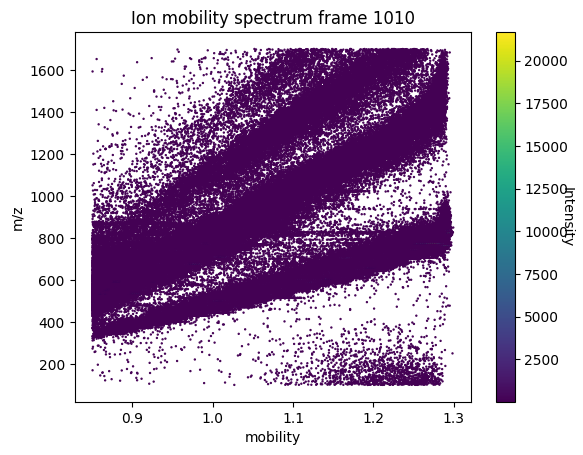

In [52]:
plot_im_mz(sliced_frame=df_1frame)

### GMM for seperate on IM dimension

In [38]:
from sklearn.mixture import GaussianMixture

X = collinear_set1_frame[
    [
        "mobility_values",
        # "mz_values",
        # "intensity_values"
    ]
].values
gm = GaussianMixture(
    n_components=5,
    random_state=0,
    means_init=collinear_candidates["Calibrated 1/K0"].values.reshape(-1, 1),
    # weights_init=normalize(potential_candidates["Intensity"].values),
)
mob_labels = gm.fit_predict(X)

NameError: name 'collinear_set1_frame' is not defined

In [48]:
plot_im_mz(sliced_frame=collinear_set1_frame, labels=mob_labels)

NameError: name 'plot_im_mz' is not defined

In [27]:
gm.means_
gm.means_init  # Calibrated 1/K0
collinear_candidates["1/K0"].values.reshape(-1, 1)  # Non Calibrated 1/K0

array([[0.92481149],
       [0.88914298],
       [0.91625054],
       [0.88143806],
       [0.93376522]])

array([[0.92615412],
       [0.90492865],
       [0.92467987],
       [0.89551326],
       [0.93545841]])

array([[0.95462341],
       [0.90771135],
       [0.93345668],
       [0.88495889],
       [0.94404402]])

##### Filter only mz with enough IM entries

In [42]:
group_by_mz = collinear_set1_frame.groupby("mz_values").size()
filtered_mz = group_by_mz[group_by_mz >= 5].index
filtered_collinear_set1_frame = collinear_set1_frame.loc[
    collinear_set1_frame["mz_values"].isin(filtered_mz)
]

In [40]:
group_by_im = collinear_set1_frame.groupby("mobility_values").size()
filtered_im = group_by_im[group_by_im >= 5].index
filtered_collinear_set1_frame = collinear_set1_frame.loc[
    collinear_set1_frame["mobility_values"].isin(filtered_im)
]

2024-03-21 10:32:27,827 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6f765453f0>


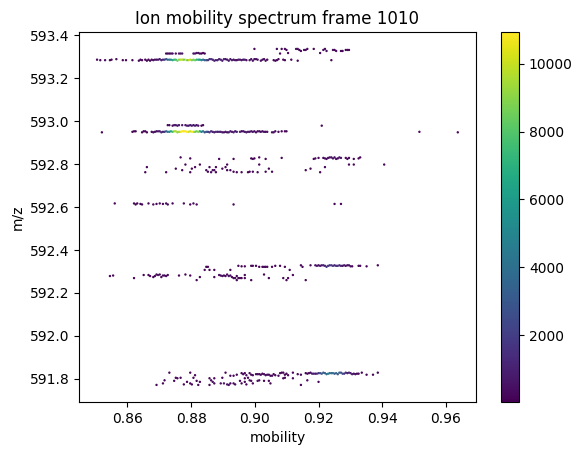

In [29]:
plot_im_mz(sliced_frame=filtered_collinear_set1_frame)

In [120]:
from sklearn.cluster import HDBSCAN

X = filtered_collinear_set1_frame[
    [
        "mobility_values",
        # "mz_values",
        # "intensity_values"
    ]
].values
hdb = HDBSCAN(min_cluster_size=3, min_samples=5)
mob_labels = hdb.fit_predict(X)

In [112]:
gm = GaussianMixture(
    n_components=5,
    random_state=0,
    means_init=collinear_candidates["Calibrated 1/K0"].values.reshape(-1, 1),
    # weights_init=normalize(potential_candidates["Intensity"].values),
)
mob_labels = gm.fit_predict(X)

2024-03-21 10:39:08,007 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6f71dd6dd0>


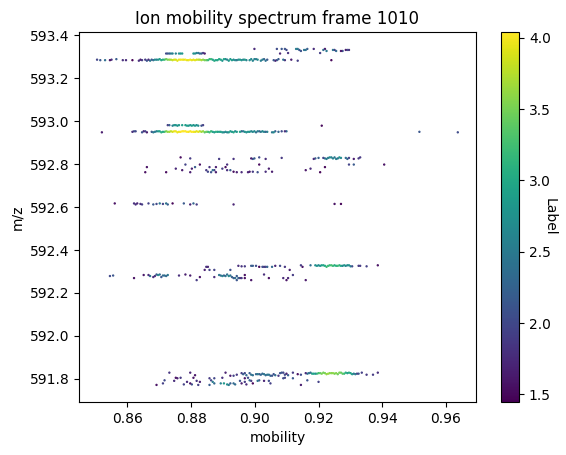

In [38]:
plot_im_mz(
    sliced_frame=filtered_collinear_set1_frame,
    labels=np.log10(filtered_collinear_set1_frame["intensity_values"] + 1),
)

In [52]:
group_by_mz = group_by_mz.sort_values(ascending=False)
group_by_im = group_by_im.sort_values(ascending=False)

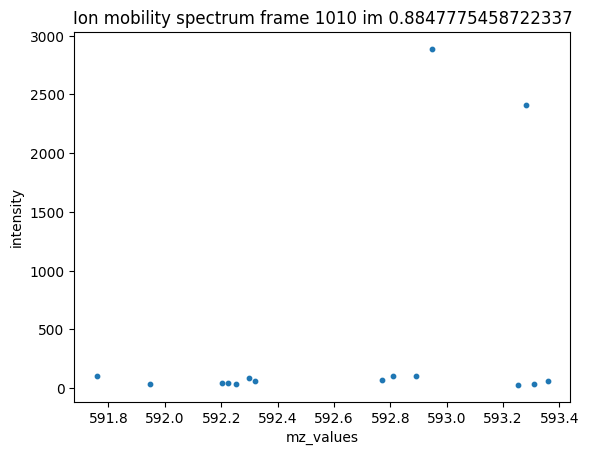

In [64]:
from utils.plot import plot_im_or_mz_int

plot_im_or_mz_int(
    sliced_frame=collinear_set1_frame,
    im_value=group_by_im.index[3],
    # labels=np.log10(1 + filtered_collinear_set1_frame["intensity_values"]),
)

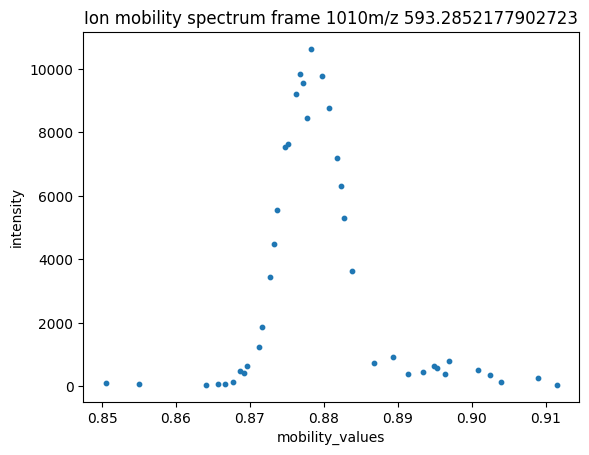

In [46]:
from utils.plot import plot_im_or_mz_int

plot_im_or_mz_int(
    sliced_frame=filtered_collinear_set1_frame, mz_value=group_by_mz.index[0]
)

## Optimization

In [31]:
obs_peak_int = scan_specific_dict.obs_peak_int
obs_peak_int_filter = obs_peak_int.loc[obs_peak_int["mzarray_obs"].isin(dict.index)]

In [33]:
len(dict.index)

9821

In [35]:
%autoreload 2
from optimization.inference import process_one_scan

scan_result, scan_dict, Quant = process_one_scan(
    scan_idx=scan_idx,
    AbundanceMissingThres=0.5,
    OneScan=OneScan,
    scan_time=ms1_scans.loc[scan_idx, "Time_minute"],
    loss="lasso",
    alpha_criteria=config["alpha_criteria"],
    alphas=[0],
    metric="RMSE",
    opt_algo="threshold",
    Maxquant_result=Maxquant_result_dict,
    preprocessing_method="raw",
    # max_iter=250,
    corr_thres=0.95,
    return_interim_results=True,
    plot_alpha_trace=False,
    plot_obs_and_infer=False,
)

2024-03-22 15:47:50,846 - optimization.inference - DEBUG - Start.
2024-03-22 15:47:50,907 - optimization.inference - DEBUG - Filter by RT.
2024-03-22 15:47:50,908 - optimization.dictionary - INFO - Number of candidates by RT 13834
2024-03-22 15:47:51,187 - optimization.dictionary - INFO - Number of candidates after isotope match 13372
2024-03-22 15:47:51,190 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 8175
2024-03-22 15:48:05,113 - optimization.dictionary - DEBUG - Number of peaks after filtering (9820, 9)
2024-03-22 15:48:05,116 - optimization.dictionary - DEBUG - Number of mz in dict (9821, 8175)
2024-03-22 15:48:05,117 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 8175
2024-03-22 15:48:09,045 - optimization.dictionary - DEBUG - Finished calculating cosine similarity.
2024-03-22 15:48:09,896 - optimization.dictionary - INFO - Number of collinear sets: 1562 
2024-03-22 15:48:09,898 - optimi

Show activation of precursors with highly correlated features

In [37]:
activation = pd.DataFrame(scan_result[scan_idx]["activation"])
# activation["cos_dist"] = Quant.calc_precursor_reconstruct_cos_dist()

In [70]:
mz_intensities[mz_intensities["precursor"].isin([92843, 131264])]

,precursor,activation,cos_dist
357,131264,2.392114e+07,1.015544


In [ ]:
mz_intensities[mz_intensities["precursor"].isin([92843, 131264])]

,precursor,activation,cos_dist
242,92843,2.382890e+07,1.030913
358,131264,2.392114e+07,1.029543


Check out the similarities in groups

In [ ]:
for group in connected_components:
    Maxquant_result_dict.loc[
        Maxquant_result_dict["id"].isin(group),
        ["id", "Calibrated retention time", "IsoMZ", "IsoAbundance"],
    ]
    print("")
Maxquant_result_dict.loc[
    Maxquant_result_dict["id"].isin([1242, 37461, 163787]),
    ["id", "Calibrated retention time", "IsoMZ", "IsoAbundance"],
]

2024-02-14 13:18:35,693 - utils.plot - DEBUG - infer m/z and intensities: Float64Index([ 483.7552822870193,   484.260342599857,  484.3239486651737,
              484.75925050429817, 486.26491183825897],
             dtype='float64'), [7.845553   7.48645162 0.         6.6786551  0.        ]


Isotope Pattern: 27304 [484.26061649 484.75913393 484.7622939  485.25851441 485.26273898
 485.26397132 485.76019183] [0.56715132 0.02073107 0.2474075  0.02538886 0.0174943  0.05261401
 0.01107534]
Isotope Pattern: 38952 [484.2556685  484.75418594 484.75734591 485.25356642 485.25586336
 485.25779099 485.25902333 485.75524384] [0.55524223 0.02435491 0.25432304 0.02485575 0.01115552 0.01370156
 0.05685825 0.01138492]
Isotope Pattern: 39511 [484.2556685  484.75418594 484.75734591 485.25356642 485.25586336
 485.25779099 485.25902333 485.75524384] [0.55524223 0.02435491 0.25432304 0.02485575 0.01115552 0.01370156
 0.05685825 0.01138492]


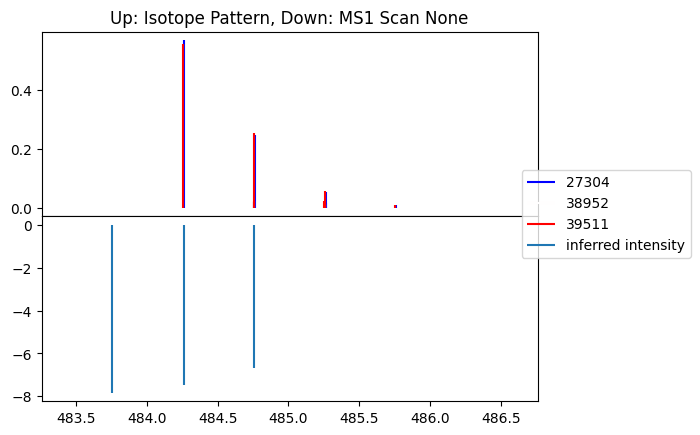

In [86]:
Quant.plot_iso_pattern_and_infer(
    Maxquant_result_dict, precursor_id=[89269, 124835, 127237], log_intensity=True
)

Remove the highly correlated precursors in one group

In [87]:
Maxquant_result_dict_mod = Maxquant_result_dict[
    ~Maxquant_result_dict["id"].isin([124835, 127237])
]
scan_result_mod, scan_dict_mod, Quant_mod = process_one_scan(
    scan_idx=scan_idx,
    AbundanceMissingThres=0.3,
    OneScan=OneScan,
    loss="lasso",
    alpha_criteria=config["alpha_criteria"],
    alphas=[0],
    metric="RMSE",
    opt_algo="threshold",
    Maxquant_result=Maxquant_result_dict_mod,
    preprocessing_method="raw",
    # max_iter=250,
    corr_thres=0.95,
    return_interim_results=True,
    plot_alpha_trace=False,
    plot_obs_and_infer=False,
)

2024-02-14 13:20:13,884 - optimization.inference - DEBUG - Start.
2024-02-14 13:20:13,891 - optimization.inference - DEBUG - Filter by RT.
2024-02-14 13:20:13,892 - optimization.dictionary - INFO - Number of candidates by RT 3294
2024-02-14 13:20:13,942 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2024-02-14 13:20:13,944 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 307
2024-02-14 13:20:13,999 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 307
2024-02-14 13:20:14,209 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 209
2024-02-14 13:20:14,211 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 183
2024-02-14 13:20:14,211 - optimization.inference - DEBUG - Construct dictionary
2024-02-14 13:20:14,213 - optimization.inference - DEBUG - obs mz (index) dimension: (865,)
2024-02-14 13

In [101]:
b = pd.DataFrame(scan_result_mod[scan_idx]["activation"])
b["cos_dist"] = Quant_mod.calc_precursor_reconstruct_cos_dist()
b[b["precursor"].isin([89269, 124835, 127237])]

,precursor,activation,cos_dist
123,89269,4.627801e+06,1.273461


2023-11-22 14:27:03,623 - result_analysis.result_analysis - DEBUG - infer m/z and intensities: Float64Index([688.798643127982, 689.2980074464168], dtype='float64'), [0. 0.]


Isotope Pattern: 14213 [688.800408   689.29892545 689.30208542 689.80060287 689.8025305
 689.80376284 690.30420792 690.30544025] [0.49150318 0.03054204 0.28409012 0.01765338 0.02627883 0.08055331
 0.01518923 0.01493435]


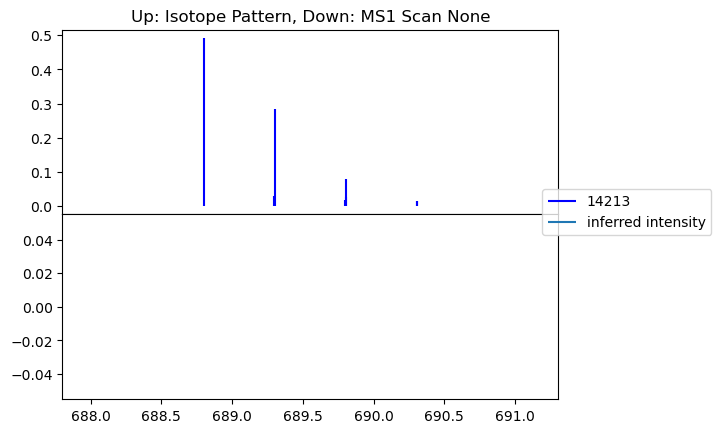

In [109]:
Quant.plot_iso_pattern_and_infer(
    Maxquant_result=Maxquant_result_dict, precursor_id=[44321], log_intensity=False
)

<module 'optimization.dictionary' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/dictionary.py'>

2023-11-22 13:25:32,210 - optimization.dictionary - INFO - Number of candidates by RT 3272
2023-11-22 13:25:32,247 - optimization.dictionary - INFO - Number of candidates after isotope match 1192
2023-11-22 13:25:32,248 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 242
2023-11-22 13:25:32,278 - optimization.dictionary - DEBUG - [Double check] Number of candidates by RT and abundance filter 242


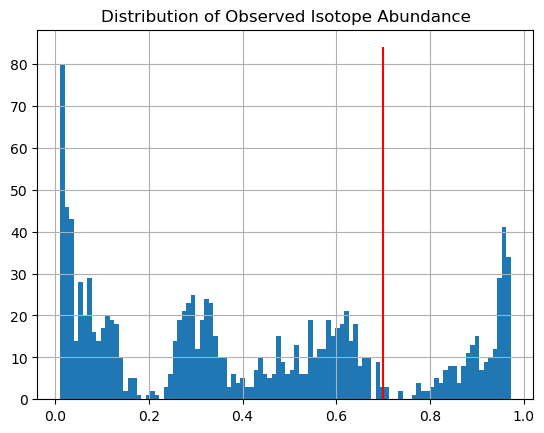

In [15]:
from optimization.dictionary import Dict
import optimization.dictionary

reload(optimization.dictionary)

CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (Maxquant_result_dict["RT_search_left"] <= OneScan["starttime"])
    & (Maxquant_result_dict["RT_search_right"] >= OneScan["starttime"])
]
ScanDict = Dict(
    CandidateByRT=CandidatePrecursorsByRT, OneScan=OneScan, AbundanceMissingThres=0.3
)
ScanDict.plot_observe_iso_abundance_hist()

2023-11-21 13:33:50,617 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


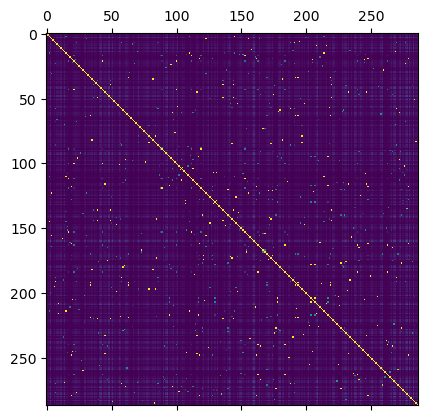

2023-11-21 13:33:51,211 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 141
2023-11-21 13:33:51,212 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 161


In [16]:
%matplotlib inline
ScanDict.get_feature_corr(corr_thres=0.95, plot_collinear_hist=False)

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

Peak results:
     apex_mzidx     apex_mz  start_mzidx    start_mz  end_mzidx      end_mz  \
0             8  600.296767            5  600.283526         10  600.305595   
1            26  600.631228           23  600.617976         28  600.640063   
2            42  600.962982           40  600.954140         45  600.976246   
3            58  601.259327           56  601.250478         61  601.272600   
4            66  601.294723           63  601.281449         69  601.307997   
..          ...         ...          ...         ...        ...         ...   
288        4273  985.599337         4271  985.580766       4276  985.627194   
289        4291  986.602845         4289  986.584246       4294  986.630745   
290        4307  987.608364         4304  987.580423       4309  987.626993   
291        4322  992.507007         4319  992.478857       4324  992.525774   
292        4336  993.502385         4334  993.483590       4339  993.531192   

     peak_width   peak_height  peak_i

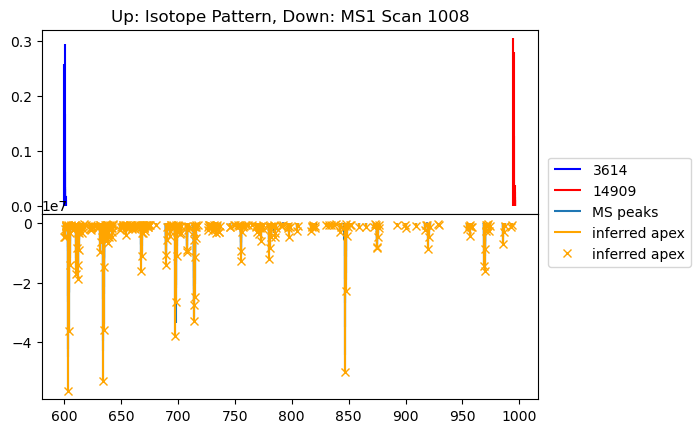

In [17]:
import result_analysis.result_analysis as RA
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

# to see peaks in a specific range
RA.PlotIsoPatternsAndScan(
    scan_idx=1008,
    precursor_idx=[3614, 14909],
    mzrange=None,
    MS1Scans=MS1Scans,
    Maxquant_result=Maxquant_result_dict,
    log_intensity=False,
)

### Explore Isotope Pattern between Sequence

In [18]:
import IsoSpecPy as iso

pair = [4129, 6698]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
4129,_ANGANTVIGPLNWDEK_,2,21.400,14850000.0,849.925926
6698,_CVDTSMGLTPLEGLVMGTR_,2,29.274,124510000.0,1018.994310


OrderedDict([('C', 74), ('H', 113), ('N', 21), ('O', 24), ('S', 0)])

OrderedDict([('C', 82), ('H', 140), ('N', 22), ('O', 27), ('S', 3)])

In [20]:
from optimization.dictionary import CalcModpeptIsopattern

CalcModpeptIsopattern(modpept="_EKVEGTIDK_", charge=2, ab_thres=0.001)

(array([509.77494504, 510.27346248, 510.27662245, 510.27705361,
        510.27808341, 510.7751399 , 510.77706753, 510.77829987,
        510.77873102, 510.77976083, 511.27681732, 511.27874495,
        511.27997729, 511.78042237, 511.78165471]),
 array([0.57300948, 0.02303972, 0.26871023, 0.00372042, 0.00510591,
        0.01080438, 0.02003166, 0.06153999, 0.00174467, 0.00239439,
        0.00247442, 0.00939376, 0.00917221, 0.00215136, 0.00100029]))

## Batch Scan Processing

In [85]:
from optimization.inference import process_scans_parallel, process_one_scan
from multiprocessing import cpu_count
import optimization.inference

reload(optimization.inference)

RT_ref == "mix"
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == "exp":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
    )
elif RT_ref == "pred":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["predicted_RT"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["predicted_RT"] + RT_tol
    )
elif RT_ref == "mix":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Retention time new"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Retention time new"] + RT_tol
    )
result_dict = process_scans_parallel(
    n_jobs=cpu_count(),
    alphas=[0, 100, 1000, 10000, 100000, 1000000],
    AbundanceMissingThres=1.0,
    MS1Scans=MS1Scans.iloc[
        638:646, :
    ],  # for small scale testing: MS1Scans.iloc[1000:1050, :]
    Maxquant_result=Maxquant_result_dict,
    preprocessing_method="raw",
    loss="lasso",
    opt_algo="threshold",
)

<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

True

2023-11-22 14:08:08,394 - optimization.dictionary - INFO - Number of candidates by RT 3274
2023-11-22 14:08:08,436 - optimization.dictionary - INFO - Number of candidates after isotope match 1484
2023-11-22 14:08:08,437 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1484
2023-11-22 14:08:10,352 - optimization.dictionary - INFO - Number of candidates by RT 3273
2023-11-22 14:08:10,407 - optimization.dictionary - INFO - Number of candidates after isotope match 1438
2023-11-22 14:08:10,408 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 1438
2023-11-22 14:08:11,990 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 106211
2023-11-22 14:08:11,995 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 1116
2023-11-22 14:08:12,014 - optimization.inference - INFO - Reached convergence criteria at alpha = 100
2023-11-22 14:08:12,015 - optimi

In [87]:
# merge results
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(
    index=Maxquant_result_dict["id"], columns=range(n_ms1scans))
scan_record_list = []
# scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation.loc[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    # scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

In [88]:
mz_intensities = activation.loc[:, 638:646]

In [141]:
from optimization.inference import process_scans_parallel
from multiprocessing import cpu_count
import optimization.inference

reload(optimization.inference)

RT_ref == "exp"
RT_tol = 1.0
# Set left and right edge for scan search range
if RT_ref == "exp":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
    )
elif RT_ref == "pred":
    Maxquant_result_dict["RT_search_left"] = (
        Maxquant_result_dict["predicted_RT"] - RT_tol
    )
    Maxquant_result_dict["RT_search_right"] = (
        Maxquant_result_dict["predicted_RT"] + RT_tol
    )
result_dict = process_scans_parallel(
    n_jobs=cpu_count(),
    MS1Scans=MS1Scans.iloc[
        1000:1010, :
    ],  # for small scale testing: MS1Scans.iloc[1000:1050, :]
    Maxquant_result=Maxquant_result_dict,
    preprocessing_method="raw",
    AbundanceMissingThres=0.5,
)

<module 'optimization.inference' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

False

2023-11-15 13:05:51,097 - optimization.dictionary - INFO - Number of candidates by RT 4638
2023-11-15 13:05:51,157 - optimization.dictionary - INFO - Number of candidates after isotope match 1674
2023-11-15 13:05:51,158 - optimization.dictionary - INFO - Number of candidates after isotope abundance filter 636
2023-11-15 13:05:51,779 - optimization.dictionary - INFO - Number of candidate pairs with correlation larger than 0.95: 362
2023-11-15 13:05:51,781 - optimization.dictionary - INFO - Number of candidated involved in high correlation: 388
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2089985829642426e+17, tolerance: 415896198849370.4
  model = cd_fast.enet_coordinate_descent_gram(
/home/zixuanxiao/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: Co

In [138]:
# merge results
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = pd.DataFrame(
    index=Maxquant_result_dict["id"], columns=range(len(result_dict))
)
scan_record_list = []
# scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation.loc[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    # scan_alignments[scan_idx] = result_dict_scan['alignment']
scan_record = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

In [60]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
scan_record_list = []
scan_alignments = {}
for scan_idx, result_dict_scan in result_dict.items():
    if result_dict_scan["activation"] is not None:
        activation[
            result_dict_scan["activation"]["precursor"], scan_idx
        ] = result_dict_scan["activation"]["activation"]
    scan_record_list.append(result_dict_scan["scans_record"])
    scan_alignments[scan_idx] = result_dict_scan["alignment"]
scan_summary = pd.DataFrame(
    scan_record_list,
    columns=[
        "Scan",
        "Time",
        "CandidatePrecursorByRT",
        "FilteredPrecursor",
        "NumberHighlyCorrDictCandidate",
        "BestAlpha",
        "Cosine Dist",
        "IntensityExplained",
    ],
)

<module 'result_analysis.result_analysis' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

-------------- Intensity -----------------
Non zero intensity in Intensity = 16871
--------------Empty Scans-----------------
-------------- Time_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Time, dtype: float64
-------------- n_CandidateByRT_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_CandidateByRT, dtype: float64
-------------- n_filteredCandidate_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: n_filteredCandidate, dtype: float64
-------------- preservedRatio_IE_filter_EmptyScans -----------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: preservedRatio_IE_filter, dtype: float64
--------------Non Empty Scans-----------------
Column  Loss do

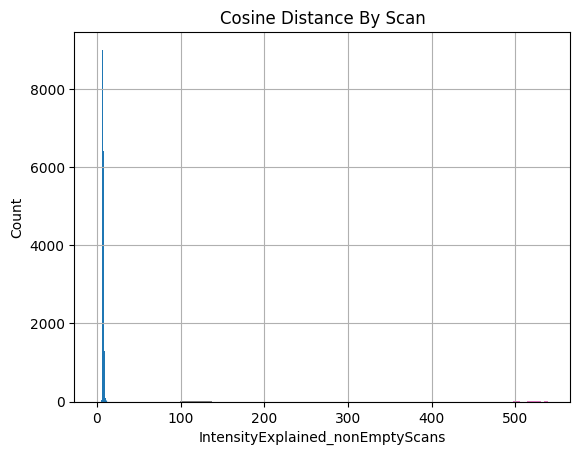

In [26]:
from result_analysis.result_analysis import GenerateResultReport
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

scan_record_processed = GenerateResultReport(
    scan_record=scan_summary, intensity_cols=[
        Maxquant_result_dict["Intensity"]]
)

In [42]:
from optimization.inference import process_scans
import optimization.inference

reload(optimization.inference)

result_dict = process_scans(
    MS1Scans=MS1Scans.iloc[600:610, :], Maxquant_result=Maxquant_result_dict
)

<module 'optimization.inference' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/inference.py'>

2023-11-06 13:53:33,942 - optimization.inference - DEBUG - Current alpha = 1e-05
2023-11-06 13:53:33,945 - optimization.inference - DEBUG - Alpha list [0, 1e-05]
2023-11-06 13:53:33,946 - optimization.inference - DEBUG - Alpha = 1e-05, tol = 0.0005284012636698199
2023-11-06 13:53:33,947 - optimization.inference - DEBUG - Current alpha = 0.0001
2023-11-06 13:53:33,950 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001]
2023-11-06 13:53:33,951 - optimization.inference - DEBUG - Alpha = 0.0001, tol = 0.0
2023-11-06 13:53:33,952 - optimization.inference - DEBUG - Current alpha = 0.001
2023-11-06 13:53:33,954 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001]
2023-11-06 13:53:33,955 - optimization.inference - DEBUG - Alpha = 0.001, tol = 0.0
2023-11-06 13:53:33,957 - optimization.inference - DEBUG - Current alpha = 0.01
2023-11-06 13:53:33,959 - optimization.inference - DEBUG - Alpha list [0, 1e-05, 0.0001, 0.001, 0.01]
2023-11-06 13:53:33,960 - optimizatio

In [ ]:
n_precursors = Maxquant_result_dict.shape[0]
n_ms1scans = MS1Scans.shape[0]
activation = np.zeros((n_precursors, n_ms1scans))
loss = []
empty_scans = []
ScanProcessRecords = {}
for scan_idx, OneScan in MS1Scans.iterrows():  # scan by scan activation
    CandidatePrecursorsByRT = Maxquant_result_dict.loc[
        (
            Maxquant_result_dict["Calibrated retention time start"] - RT_tol
            <= OneScan["starttime"]
        )
        & (
            Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
            >= OneScan["starttime"]
        )
    ]
    if CandidatePrecursorsByRT.shape[0] > 0:
        (
            CandidateDict,
            CandidatePrecursorsByRT,
            alignment,
            IsotopeNotObs,
            y_true,
            peak_results,
        ) = ConstructDict(CandidatePrecursorsByRT, OneScan, method="peakRange")
        filteredPrecursorIdx = np.array(CandidateDict.columns[1:], dtype=int)
        if CandidateDict.shape[1] > 1:
            (
                activationByScan,
                lossByScan,
                scoreByScan,
                pred,
                explainedInt,
                explainedPeaks,
            ) = CalcPrecursorQuant(
                CandidateDict,
                y_true,
                filteredPrecursorIdx=filteredPrecursorIdx,
                alpha=alpha,
            )
            activation[filteredPrecursorIdx, scan_idx] = activationByScan
            loss.append(lossByScan)
            score.append(scoreByScan)
            RA.PlotTrueAndPredict(
                x=CandidateDict.index,
                prediction=pred,
                true=y_true["intensity"],
                log=True,
            )
        else:
            lossByScan = None
            print(
                "Scan number, start time ",
                scan_idx,
                OneScan["starttime"],
                "does not have valid candidate.",
            )
            empty_scans.append((scan_idx, OneScan["starttime"]))
        ScanProcessRecords[scan_idx] = {
            "CandidatePrecursorIdx": CandidatePrecursorsByRT.index,
            "FilteredCandidatePrecursor": filteredPrecursorIdx,
            "Residue": lossByScan,
            "alignment": alignment,
        }
    else:
        print(
            "Scan number, start time ",
            scan_idx,
            OneScan["starttime"],
            "does not have valid candidate.",
        )

In [ ]:
empty_scans = pd.DataFrame(empty_scans, columns=["Scan", "Time"])

In [ ]:
tmp = activation[:, 2400:2500]
mz_intensities = tmp.sum(axis=1)
np.array(mz_intensities > 0).sum()

In [ ]:
activationSumByScan = activation.sum(axis=0)
np.array(activationSumByScan > 0).sum()

In [ ]:
activationSumByPrecursor = activation.sum(axis=1)
np.array(activationSumByPrecursor > 0).sum()

In [ ]:
Intensity_comparison = pd.DataFrame(
    {"MQ_int": Maxquant_result_dict["Intensity"],
        "Inf_int": activationSumByPrecursor}
)
Intensity_comparison = Intensity_comparison[
    Intensity_comparison["Inf_int"] > 0
].dropna()

In [ ]:
np.save(output_file + "_activationByScanFromLasso.npy", activation)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=range(1650, 1700), y=activation[17754, 1650:1700])